# Sequential Fish : Testing for pipeline (Sandbox)

Testing correction for uniform spatial drift.

## Open images

In [2]:
from pbwrap.utils import open_image

dapi_path = "/media/floricslimani/SSD4To/SSD_floricslimani/Fish_seq/Davide/2024-08-12 - SeqFISH - HeLa - Puro - R2TP1-2_Run7/DAPI_Z-stacks/Location-01/img000_000_000000_0000000000.ome.tif"
fish_path = "/media/floricslimani/SSD4To/SSD_floricslimani/Fish_seq/Davide/2024-08-12 - SeqFISH - HeLa - Puro - R2TP1-2_Run7/FISH_Z-stacks/Location-01/img000_000_000000_0000000000.ome.tif"

dapi = open_image(dapi_path)
fish = open_image(fish_path)
print("Images shapes :")
print("DAPI : ", dapi.shape)
print("FISH : ", fish.shape)

#Keeping only 1st stack for fish image and bead channel
dapi = dapi[:,-1,:,:]
fish = fish[0,1:,:,:,-1]

print("Images shapes after selection :")
print("DAPI : ", dapi.shape)
print("FISH : ", fish.shape)

images = {
    'dapi' : dapi,
    'fish' : fish,
}


Images shapes :
DAPI :  (46, 2, 1981, 2004)
FISH :  (14, 56, 1981, 2004, 3)
Images shapes after selection :
DAPI :  (46, 1981, 2004)
FISH :  (55, 1981, 2004)


## Beads detection

In this test beads are detected with same process than spot detection but with important threshold. Those could be different from dapi to fish stacks.
We try to refine the detection of beads by keeping only spots that have a matching bead. 
This is achieved by computing a distance threshold using the most common distance to closest bead, to avoid mistake from false spots surdetection the symetric test is performed to ensure same threshold is found.

### Import and parameters

In [7]:
import numpy as np
import pbwrap.detection as detection
import bigfish.plot as plot

voxel_size = (200,97,97) #nm/px
bead_size = (103,103,103) #nm/px
threshold_penalty = 10

### Detection

In [8]:
dapi_beads, dapi_threshold = detection.detect_spots(
    images= dapi,
    threshold_penalty=10,
    voxel_size=voxel_size,
    spot_radius= bead_size,
    return_threshold=True,
    ndim=3
)

print("Threshold for beads in dapi : ", dapi_threshold)
print(len(dapi_beads)," spots detected")

Threshold for beads in dapi :  21490.0
341  spots detected


In [9]:
fish_beads, fish_threshold = detection.detect_spots(
    images= fish,
    threshold_penalty=1.5,
    voxel_size=voxel_size,
    spot_radius= bead_size,
    return_threshold=True,
    ndim=3
)

print("Threshold for beads in dapi : ", fish_threshold)
print(len(fish_beads)," spots detected")

Threshold for beads in dapi :  2226.0
370  spots detected


### Napari visualisation

In [7]:
import napari

Viewer = napari.Viewer()

#images
Viewer.add_image(
    dapi,
    scale=voxel_size,
    blending='additive',
    colormap='blue'
)
Viewer.add_image(
    fish,
    scale=voxel_size,
    blending='additive',
    colormap='green'
)

#spots
Viewer.add_points(
    dapi_beads,
    scale=voxel_size,
    face_color='blue',
    symbol= 'ring',
    visible=False,
)

Viewer.add_points(
    fish_beads,
    scale=voxel_size,
    face_color='green',
    symbol= 'ring',
    visible=False,
)


Viewer.show()
napari.run()



## Beads alignement

Now we try to find the shift value in all directions, dz,dy,dx.
In this approach we use the average distance between beads and their closest beads.

### Selecting spots that have a matching bead found.

Here we create distance map representing the distance to the closest bead detected for both images.

In [10]:
from scipy.ndimage import distance_transform_edt
import numpy as np

max_zdim = max(fish.shape[0], dapi.shape[0])
shape = (max_zdim,) + fish.shape[1:]

dapi_beads_array = np.ones(shape)
fish_beads_array = np.ones(shape)

z_dapi,y_dapi,x_dapi = zip(*dapi_beads)
z_fish,y_fish,x_fish = zip(*fish_beads)
dapi_beads_array[z_dapi,y_dapi,x_dapi] = 0
fish_beads_array[z_fish,y_fish,x_fish] = 0

dapi_map, dapi_indices = distance_transform_edt(
    input=dapi_beads_array,
    sampling=voxel_size,
    return_indices= True,
)
fish_map, fish_indices = distance_transform_edt(
    input=fish_beads_array,
    sampling=voxel_size,
    return_indices= True,
)

distance_dapi_from_fish = fish_map[z_dapi,y_dapi,x_dapi]
distance_fish_from_dapi = dapi_map[z_fish,y_fish,x_fish]

assert len(distance_dapi_from_fish) == len(dapi_beads)
assert len(distance_fish_from_dapi) == len(fish_beads)

Plotting distance distributions

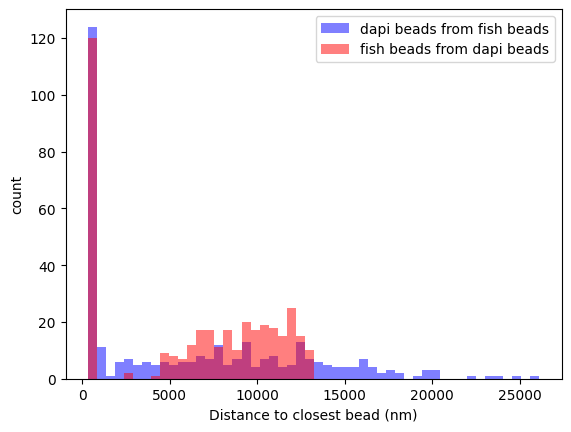

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca()

bins = 50

count_dapi,value_dapi,_ = ax.hist(distance_dapi_from_fish, bins=bins, label="dapi beads from fish beads", alpha = 0.5, color='blue')
count_fish, value_fish,_ = ax.hist(distance_fish_from_dapi, bins=value_dapi, label="fish beads from dapi beads", alpha = 0.5, color='red')

ax.set_xlabel('Distance to closest bead (nm)')
ax.set_ylabel('count')
ax.legend()

plt.show()


Now we retrieve the value of the biggest bin to use as a threshold to select correct spots.

In [12]:
dapi_max_pos = np.argmax(count_dapi)
fish_max_pos = np.argmax(count_fish)
dapi_value = value_dapi[dapi_max_pos+1] # all value of spot in bins are within value_dapi[i] and value_dapi[i+1] so we take right value to be used as a threshold.
fish_value = value_fish[fish_max_pos+1] # all value of spot in bins are within value_dapi[i] and value_dapi[i+1] so we take right value to be used as a threshold.

assert dapi_value == fish_value, "Different value found for symetric test. Likely, in most case matching beads were not detected.\n fish : {0}; dapi : {1}".format(fish_value,dapi_value)
distance_threshold = fish_value
print("Value to use as threshold : ", distance_threshold)

Value to use as threshold :  864.8785898834082


For penalty :

dapi : 10 ; fish 1.5 --> 864nm

dapi : 10 , fish 1 --> 850nm

dapi : 1  , fish 1 --> 933 nm

dapi : 10 , fish 10 --> AssertionError: Different value found for symetric test, one spot detection must be incorect.
 fish : 4804.319376807936; dapi : 169623.8127910613

### Storing spots and applying threshold

We put data in a dataframe and remove spot whose closest bead found is above `distance_threshold`.

First, we are gonna use the `fish_indices` computed along with the distance map to find the matching spots. Those indices arrays contain the coordinate of the closest spots.

In [10]:
dapi_matching_z = fish_indices[0][z_dapi,y_dapi,x_dapi]
dapi_matching_y = fish_indices[1][z_dapi,y_dapi,x_dapi]
dapi_matching_x = fish_indices[2][z_dapi,y_dapi,x_dapi]

fish_matching_z = dapi_indices[0][z_fish,y_fish,x_fish]
fish_matching_y = dapi_indices[1][z_fish,y_fish,x_fish]
fish_matching_x = dapi_indices[2][z_fish,y_fish,x_fish]

Now we build the dataframe.

In [11]:
import pandas as pd

distance_df = pd.concat([
    pd.DataFrame({
        'channel' : ['dapi'] * len(dapi_beads),
        'distance_to_closest_spot' : distance_dapi_from_fish,
        'z' : z_dapi,
        'matching_z' : dapi_matching_z,
        'y' : y_dapi,
        'matching_y' : dapi_matching_y,
        'x' : x_dapi,
        'matching_x' : dapi_matching_x,
    }),
    pd.DataFrame({
        'channel' : ['fish'] * len(fish_beads),
        'distance_to_closest_spot' : distance_fish_from_dapi,
        'z' : z_fish,
        'matching_z' : fish_matching_z,
        'y' : y_fish,
        'matching_y' : fish_matching_y,
        'x' : x_fish,
        'matching_x' : fish_matching_x,
    })
],axis=0)
distance_df = distance_df.reset_index(drop=False)

previous_len = len(distance_df)

print(distance_df)

     index channel  distance_to_closest_spot   z  matching_z     y  \
0        0    dapi                590.027965   0           0   100   
1        1    dapi                590.027965   0           0   128   
2        2    dapi                590.027965   0           0   132   
3        3    dapi                623.003210   0           1   137   
4        4    dapi                522.360986   0           0   184   
..     ...     ...                       ...  ..         ...   ...   
706    365    fish                533.511012  36          37    32   
707    366    fish                533.511012  36          37    62   
708    367    fish               2818.046132  38          34  1107   
709    368    fish                559.339789  38          39  1407   
710    369    fish                712.834483  39          41  1479   

     matching_y     x  matching_x  
0            94   331         330  
1           122  1586        1585  
2           126  1594        1593  
3           131

Finally we apply distance threshold : 

In [12]:
distance_df = distance_df.loc[distance_df['distance_to_closest_spot'] <= distance_threshold]

print('{0} spots were removed, {1} are remaining'.format(-len(distance_df) + previous_len,  len(distance_df)))
print(distance_df)

467 spots were removed, 244 are remaining
     index channel  distance_to_closest_spot   z  matching_z     y  \
0        0    dapi                590.027965   0           0   100   
1        1    dapi                590.027965   0           0   128   
2        2    dapi                590.027965   0           0   132   
3        3    dapi                623.003210   0           1   137   
4        4    dapi                522.360986   0           0   184   
..     ...     ...                       ...  ..         ...   ...   
705    364    fish                533.511012  36          35    26   
706    365    fish                533.511012  36          37    32   
707    366    fish                533.511012  36          37    62   
709    368    fish                559.339789  38          39  1407   
710    369    fish                712.834483  39          41  1479   

     matching_y     x  matching_x  
0            94   331         330  
1           122  1586        1585  
2        

### Finding the shift value

Next step is to compute the distance in each directions from one bead to its matching bead.

In [13]:
distance_df['dz'] = distance_df['matching_z'] - distance_df['z']
distance_df['dy'] = distance_df['matching_y'] - distance_df['y']
distance_df['dx'] = distance_df['matching_x'] - distance_df['x']

delta_df:pd.DataFrame = distance_df.loc[:,['channel','dz','dy','dx']]
print(delta_df)



    channel  dz  dy  dx
0      dapi   0  -6  -1
1      dapi   0  -6  -1
2      dapi   0  -6  -1
3      dapi   1  -6  -1
4      dapi   0  -5  -2
..      ...  ..  ..  ..
705    fish  -1   5   1
706    fish   1   5   1
707    fish   1   5   1
709    fish   1   5   2
710    fish   2   6   1

[244 rows x 4 columns]


Finally we compute some statistics about the shift between beads.

                shift                      
                 mean median       std mode
channel dim                                
dapi    dx  -1.362903   -1.0  0.736225   -1
        dy  -5.451613   -6.0  0.690879   -6
        dz  -0.338710    0.0  1.019223    0
fish    dx   1.416667    1.0  0.642779    1
        dy   5.500000    6.0  0.608069    6
        dz   0.200000    0.0  0.922182    0


<Axes: title={'center': 'Fish beads'}, ylabel='Frequency'>

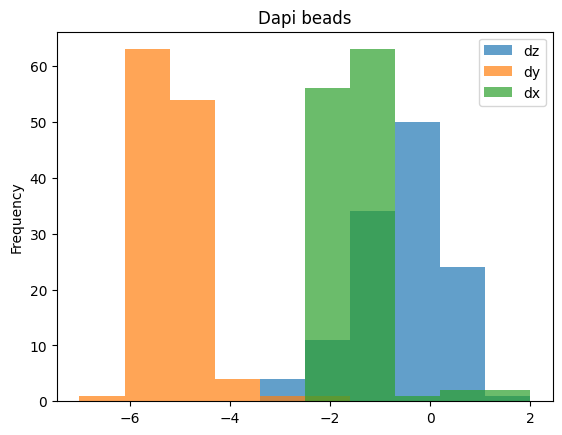

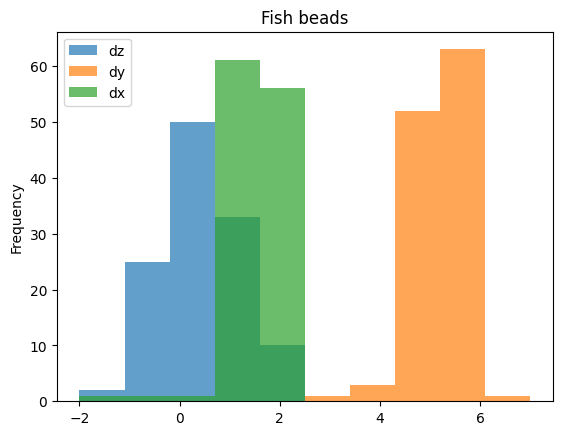

In [14]:
agg_df = delta_df.melt(
    id_vars='channel',
    value_vars=['dz','dy','dx'],
    value_name= 'shift',
    var_name= 'dim'
    
)
agg_df = agg_df.groupby(['channel','dim']).agg(['mean','median','std',pd.Series.mode])
print(agg_df)


distance_df.loc[distance_df['channel'] == 'dapi',['dz','dy','dx']].plot(
    kind= 'hist',
    bins = 10,
    alpha=0.7,
    title='Dapi beads'
)

distance_df.loc[distance_df['channel'] == 'fish',['dz','dy','dx']].plot(
    kind= 'hist',
    bins = 10,
    alpha=0.7,
    title='Fish beads'
)

# dx,dy,dz = agg_df.loc[:,('shift','mean')].apply(round)

# print("\nKept shift after rounding")
# print('dx : ', dx,)
# print('dy : ', dy,)
# print('dz : ', dz,)

### Napari visualisation of corrected spots.

Note in this notebook the ref spots are dapi.

In [15]:
def shift_array(arr : np.ndarray,*args) :
    indexer_new_array = []
    indexer_old_array = []
    for delta in args :
        if delta == 0 : 
            indexer_new_array.append(slice(None))
            indexer_old_array.append(slice(None))
        elif delta > 0 :
            indexer_new_array.append(slice(delta,None))
            indexer_old_array.append(slice(None,-delta))

        else :
            indexer_new_array.append(slice(None,delta))
            indexer_old_array.append(slice(-delta,None))

    if len(args) < arr.ndim :
        indexer_old_array.append(...)
        indexer_new_array.append(...)

    indexer_new_array = tuple(indexer_new_array)
    indexer_old_array = tuple(indexer_old_array)
    new_arr = np.zeros_like(arr)

    if len(args) > arr.ndim :
        raise ValueError("too many axis to shift")
    else :
        new_arr[indexer_new_array] = arr[indexer_old_array]
        new_arr[indexer_new_array] = arr[indexer_old_array]

    return new_arr



In [16]:
dx,dy,dz = agg_df.loc[('dapi'),('shift','mean')].round().astype(int)
print('dx : ',dx)
print('dy : ',dy)
print('dz : ',dz)

new_dapi = shift_array(dapi, dz,dy,dx)

dx :  -1
dy :  -5
dz :  0


### Napari visualisation

In [19]:
import napari

Viewer = napari.Viewer()

#images
Viewer.add_image(
    dapi,
    scale=voxel_size,
    blending='additive',
    colormap='blue'
)
Viewer.add_image(
    new_dapi,
    scale=voxel_size,
    blending='additive',
    colormap='red'
)
Viewer.add_image(
    fish,
    scale=voxel_size,
    blending='additive',
    colormap='green'
)



Viewer.show()
napari.run()



# Alignement module testing

Testing module version of above code.

## Open images

In [1]:
from pbwrap.utils import open_image

dapi_path = "/media/floricslimani/SSD4To/SSD_floricslimani/Fish_seq/Davide/2024-08-12 - SeqFISH - HeLa - Puro - R2TP1-2_Run7/DAPI_Z-stacks/Location-01/img000_000_000000_0000000000.ome.tif"
fish_path = "/media/floricslimani/SSD4To/SSD_floricslimani/Fish_seq/Davide/2024-08-12 - SeqFISH - HeLa - Puro - R2TP1-2_Run7/FISH_Z-stacks/Location-01/img000_000_000000_0000000000.ome.tif"
path_output = '/media/floricslimani/SSD4To/SSD_floricslimani/Fish_seq/Davide/2024-08-12 - SeqFISH - HeLa - Puro - R2TP1-2_Run7/test_drift_correction_output'

dapi = open_image(dapi_path)
fish = open_image(fish_path)

#Keeping only 1st stack for fish image and bead channel
dapi = dapi[:,-1,:,:]
fish = fish[0,1:,:,:,-1]

print("Images shapes :")
print("DAPI : ", dapi.shape)
print("FISH : ", fish.shape)

images = {
    'dapi' : dapi,
    'fish' : fish,
}


Images shapes :
DAPI :  (46, 1981, 2004)
FISH :  (55, 1981, 2004)


reference beads number :  370 
drift beads nuber :  582


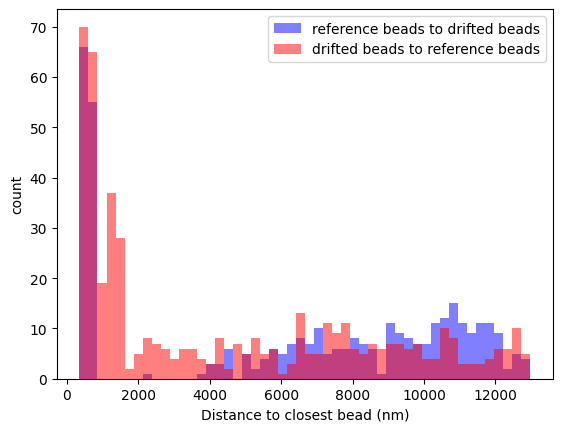

Distance threshold :  602.3822360547356


In [2]:
from pbwrap.preprocessing import find_drift
import os
os.makedirs(path_output, exist_ok=True)
drift = find_drift(
    reference_bead_signal = fish,
    drifted_bead_signal = dapi,
    voxel_size = (200,97,97),
    bead_size = (103,103,103),
    drift_threshold_penalty=3,
    reference_threshold_penalty=1.5,
    plot_path = path_output,
    talk=True
)

In [16]:
print(drift)

(-1, -5, 0)


*   reference_bead_signal = fish,
*    drifted_bead_signal = dapi,
*    voxel_size = (200,97,97),
*    bead_size = (103,103,103),
*    drift_threshold_penalty=10,
*    reference_threshold_penalty=1.5,
*    plot_path = path_output,
*    talk=True

(-1, -5, 0)

*    reference_bead_signal = fish,
*    drifted_bead_signal = dapi,
*    voxel_size = (200,97,97),
*    bead_size = (103,103,103),
*    drift_threshold_penalty=2,
*    reference_threshold_penalty=2,
*    plot_path = path_output,
*    talk=True

(-1, -5, 0)

*    reference_bead_signal = fish,
*    drifted_bead_signal = dapi,
*    voxel_size = (200,97,97),
*    bead_size = (103,103,103),
*    drift_threshold_penalty=3,
*    reference_threshold_penalty=1.5,
*    plot_path = path_output,
*    talk=True

(-1, -5, 0)


### Check correction is on good direction : OK

In [9]:
from pbwrap.preprocessing import shift_array
corrected_signal = shift_array(dapi, *drift)

In [30]:
import napari

viewer = napari.Viewer()
viewer.add_image(dapi, name='drift')
viewer.add_image(fish, name='reference')
viewer.add_image(corrected_signal, name='corrected_signal')
napari.run()

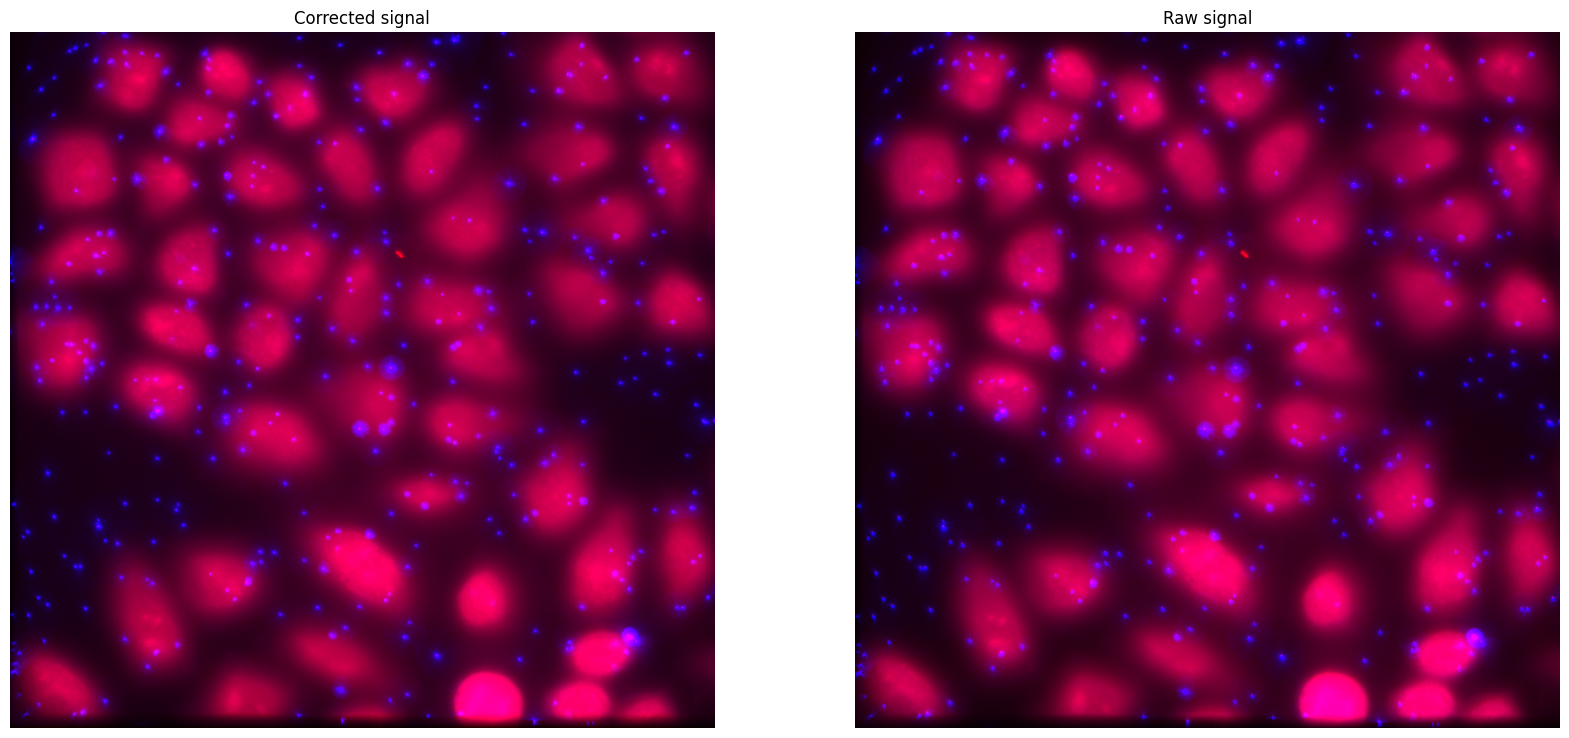

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import bigfish.stack as stack

fig = plt.figure(figsize=(20,10))
left,right = fig.subplots(1,2)
image_rgb = np.zeros(
    list(np.max([fish.shape, dapi.shape], axis= 0))
    + [3]
,dtype=float)
fish = stack.rescale(fish, channel_to_stretch=0)
dapi = stack.rescale(dapi, channel_to_stretch=0)
corrected_signal = stack.rescale(corrected_signal, channel_to_stretch=0)


image_rgb[0:fish.shape[0], 0: fish.shape[1], 0:fish.shape[2], 0] = fish / fish.max()
image_rgb[0:corrected_signal.shape[0], 0: corrected_signal.shape[1], 0:corrected_signal.shape[2], 2] = corrected_signal / corrected_signal.max()

left.imshow(np.max(image_rgb, axis=0))
left.set_title('Corrected signal')

image_rgb[0:dapi.shape[0], 0: dapi.shape[1], 0:dapi.shape[2], 2] = dapi / dapi.max()

right.imshow(np.max(image_rgb, axis=0))
right.set_title('Raw signal')

left.axis('off')
right.axis('off')
plt.tight_layout()
plt.show()
